### Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import itertools
import seaborn as sns

### Imbalanced data

In [2]:
# Read in data

t0 = time.time()
df = pd.read_csv('aggregate-20160501.csv')
t1 = time.time()
print(str((t1-t0)/60) + " minutes")

6.1703662991523744 minutes


In [3]:
#df.head()
#df.shape
#df.columns
#set(df.num_edits)

In [4]:
# Calculate percentage of unedited articles in original imbalanced data

len(df["num_edits"][df["num_edits"] == 0])/len(df["num_edits"])*100

99.91720181519122

In [5]:
# Check missingness in original imbalanced data

print(df.isnull().sum())

article_name                   1
num_edits                      0
views_30d                      0
views_7d                       0
views_3d                       0
views_1d                       0
edits_30d                      0
edits_7d                       0
edits_3d                       0
edits_1d                       0
minor_edits_30d                0
minor_edits_7d                 0
minor_edits_3d                 0
minor_edits_1d                 0
avg_size_30d             6428583
avg_size_7d             45268487
avg_size_3d             49800824
avg_size_1d             53028939
avg_size                  209968
latest_size               209968
talk_views_30d                 0
talk_views_7d                  0
talk_views_3d                  0
talk_views_1d                  0
talk_edits_30d                 0
talk_edits_7d                  0
talk_edits_3d                  0
talk_edits_1d                  0
talk_minor_edits_30d           0
talk_minor_edits_7d            0
talk_minor

In [6]:
# Generate binary edited vs. unedited variable

df['num_edits_binary'] = df['num_edits'].apply(lambda x: int(x > 0))
#set(df['num_edits_binary'])

In [7]:
# Store relevant variable names in a list

feature_names = [x for x in df.columns if 'num_edits' not in x and 'article_name' not in x]

label_name = "num_edits_binary"

feature_names

['views_30d',
 'views_7d',
 'views_3d',
 'views_1d',
 'edits_30d',
 'edits_7d',
 'edits_3d',
 'edits_1d',
 'minor_edits_30d',
 'minor_edits_7d',
 'minor_edits_3d',
 'minor_edits_1d',
 'avg_size_30d',
 'avg_size_7d',
 'avg_size_3d',
 'avg_size_1d',
 'avg_size',
 'latest_size',
 'talk_views_30d',
 'talk_views_7d',
 'talk_views_3d',
 'talk_views_1d',
 'talk_edits_30d',
 'talk_edits_7d',
 'talk_edits_3d',
 'talk_edits_1d',
 'talk_minor_edits_30d',
 'talk_minor_edits_7d',
 'talk_minor_edits_3d',
 'talk_minor_edits_1d',
 'talk_avg_size_30d',
 'talk_avg_size_7d',
 'talk_avg_size_3d',
 'talk_avg_size_1d',
 'talk_avg_size',
 'talk_latest_size']

### Balanced data

In [8]:
## Generate balanced sample

t0 = time.time()

np.random.seed(seed=13579)

# to be set aside as imbalanced test data
set1_idx = np.random.choice(range(len(df)), int(len(df) * .2), replace=False)
set1_X = df.loc[set1_idx, feature_names]
set1_Y = df.loc[set1_idx, label_name]

# to be used to generate balanced data for main analysis
set2_idx = list(set(range(len(df))) - set(list(set1_idx)))
set2 = df.loc[set2_idx, list(df.columns.tolist())]

edited = set2[set2.num_edits > 0.0].copy(deep=True)
#edited.shape

not_edited = set2[set2.num_edits == 0.0].copy(deep=True)

not_edited_selected = not_edited[0:edited.shape[0]]

balanced_set = pd.concat([edited, not_edited_selected])

balanced_set = shuffle(balanced_set)
#balanced_set.shape

t1 = time.time()
print(str((t1-t0)/60) + " minutes")

5.024468239148458 minutes


In [9]:
print(edited.shape)
print(balanced_set.shape)

(41624, 39)
(83248, 39)


In [10]:
# Write balanced data to csv

balanced_set.to_csv('balanced_set_20160501.csv', sep=',')
#balanced_set.head()

In [11]:
# Read in balanced data

df_b = pd.read_csv('balanced_set_20160501.csv')
df_b = df_b.set_index('Unnamed: 0')
df_b.index.name = None
#df_b.head()

In [12]:
# Calculate percentage of unedited articles in balanced data

len(df_b["num_edits_binary"][df_b["num_edits_binary"] == 0])/len(df_b["num_edits_binary"])*100

50.0

In [13]:
# Check missingness in balanced data

print(df_b.isnull().sum())

article_name                0
num_edits                   0
views_30d                   0
views_7d                    0
views_3d                    0
views_1d                    0
edits_30d                   0
edits_7d                    0
edits_3d                    0
edits_1d                    0
minor_edits_30d             0
minor_edits_7d              0
minor_edits_3d              0
minor_edits_1d              0
avg_size_30d              496
avg_size_7d              7505
avg_size_3d              9725
avg_size_1d             10885
avg_size                    1
latest_size                 1
talk_views_30d              0
talk_views_7d               0
talk_views_3d               0
talk_views_1d               0
talk_edits_30d              0
talk_edits_7d               0
talk_edits_3d               0
talk_edits_1d               0
talk_minor_edits_30d        0
talk_minor_edits_7d         0
talk_minor_edits_3d         0
talk_minor_edits_1d         0
talk_avg_size_30d       17892
talk_avg_s

### New Features

In [14]:
# Generate features

# Views

df_b['total_views'] = df_b.views_1d + df_b.views_3d + df_b.views_7d + df_b.views_30d

# Version 1

df_b['change_in_views_v1_7_30'] = df_b.views_7d/4 - df_b.views_30d/23

df_b['change_in_views_v1_3_7'] = df_b.views_3d/2 - df_b.views_7d/4 

df_b['change_in_views_v1_1_3'] = df_b.views_1d/1 - df_b.views_3d/2

# Version 2

df_b['change_in_views_v2_7_30'] = ((df_b.views_7d/4)+1)/((df_b.views_30d/23)+1)

df_b['change_in_views_v2_3_7'] = ((df_b.views_3d/2)+1)/((df_b.views_7d/4)+1)

df_b['change_in_views_v2_1_3'] = ((df_b.views_1d/1)+1)/((df_b.views_3d/2)+1)

#df_b['total_views'].describe()

In [15]:
# Edits

df_b['total_edits'] = df_b.edits_1d + df_b.edits_3d + df_b.edits_7d + df_b.edits_30d

# Version 1

df_b['change_in_edits_v1_7_30'] = df_b.edits_7d/4 - df_b.edits_30d/23

df_b['change_in_edits_v1_3_7'] = df_b.edits_3d/2 - df_b.edits_7d/4

df_b['change_in_edits_v1_1_3'] = df_b.edits_1d/1 - df_b.edits_3d/2

# Version 2

df_b['change_in_edits_v2_7_30'] = ((df_b.edits_7d/4)+1)/((df_b.edits_30d/23)+1)

df_b['change_in_edits_v2_3_7'] = ((df_b.edits_3d/2)+1)/((df_b.edits_7d/4)+1)

df_b['change_in_edits_v2_1_3'] = ((df_b.edits_1d/1)+1)/((df_b.edits_3d/2)+1)

#df_b['total_edits'].describe()

In [16]:
# Minor edits

df_b['total_minor_edits'] = df_b.minor_edits_1d + df_b.minor_edits_3d + df_b.minor_edits_7d + df_b.minor_edits_30d

# Version 1

df_b['change_in_minor_edits_v1_7_30'] = df_b.minor_edits_7d/4 - df_b.minor_edits_30d/23

df_b['change_in_minor_edits_v1_3_7'] = df_b.minor_edits_3d/2 - df_b.minor_edits_7d/4

df_b['change_in_minor_edits_v1_1_3'] = df_b.minor_edits_1d/1 - df_b.minor_edits_3d/2

# Version 2

df_b['change_in_minor_edits_v2_7_30'] = ((df_b.minor_edits_7d/4)+1)/((df_b.minor_edits_30d/23)+1)

df_b['change_in_minor_edits_v2_3_7'] = ((df_b.minor_edits_3d/2)+1)/((df_b.minor_edits_7d/4)+1)

df_b['change_in_minor_edits_v2_1_3'] = ((df_b.minor_edits_1d/1)+1)/((df_b.minor_edits_3d/2)+1)

#df_b['total_minor_edits'].describe()

In [17]:
# Average size

# Version 1

df_b['change_in_avg_size_v1_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (x['avg_size_7d']/4 - x['avg_size_30d']/23), 
    axis=1
)

df_b['change_in_avg_size_v1_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (x['avg_size_3d']/2 - x['avg_size_7d']/4), 
    axis=1
)

df_b['change_in_avg_size_v1_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (x['avg_size_1d']/1 - x['avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_avg_size_v2_7_30'] = df_b[['avg_size_7d', 'avg_size_30d', 'edits_7d', 'edits_30d']].apply(
    lambda x: 0
    if (x['edits_7d'] + x['edits_30d'] == 0)
    else (((x['avg_size_7d']/4)+1)/((x['avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_3_7'] = df_b[['avg_size_3d', 'avg_size_7d', 'edits_3d', 'edits_7d']].apply(
    lambda x: 0
    if (x['edits_3d'] + x['edits_7d'] == 0)
    else (((x['avg_size_3d']/2)+1)/((x['avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_avg_size_v2_1_3'] = df_b[['avg_size_1d', 'avg_size_3d', 'edits_1d', 'edits_3d']].apply(
    lambda x: 0
    if (x['edits_1d'] + x['edits_3d'] == 0)
    else (((x['avg_size_1d']/1)+1)/((x['avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_avg_size_v2_1_3'].describe()

In [18]:
# Talk views

df_b['total_talk_views'] = df_b.talk_views_1d + df_b.talk_views_3d + df_b.talk_views_7d + df_b.talk_views_30d

# Version 1

df_b['change_in_talk_views_v1_7_30'] = df_b.talk_views_7d/4 - df_b.talk_views_30d/23

df_b['change_in_talk_views_v1_3_7'] = df_b.talk_views_3d/2 - df_b.talk_views_7d/4 

df_b['change_in_talk_views_v1_1_3'] = df_b.talk_views_1d/1 - df_b.talk_views_3d/2

# Version 2

df_b['change_in_talk_views_v2_7_30'] = ((df_b.talk_views_7d/4)+1)/((df_b.talk_views_30d/23)+1)

df_b['change_in_talk_views_v2_3_7'] = ((df_b.talk_views_3d/2)+1)/((df_b.talk_views_7d/4)+1)

df_b['change_in_talk_views_v2_1_3'] = ((df_b.talk_views_1d/1)+1)/((df_b.talk_views_3d/2)+1)

#df_b['total_talk_views'].describe()

In [19]:
# Talk edits

df_b['total_talk_edits'] = df_b.talk_edits_1d + df_b.talk_edits_3d + df_b.talk_edits_7d + df_b.talk_edits_30d

# Version 1

df_b['change_in_talk_edits_v1_7_30'] = df_b.talk_edits_7d/4 - df_b.talk_edits_30d/23

df_b['change_in_talk_edits_v1_3_7'] = df_b.talk_edits_3d/2 - df_b.talk_edits_7d/4

df_b['change_in_talk_edits_v1_1_3'] = df_b.talk_edits_1d/1 - df_b.talk_edits_3d/2

# Version 2

df_b['change_in_talk_edits_v2_7_30'] = ((df_b.talk_edits_7d/4)+1)/((df_b.talk_edits_30d/23)+1)

df_b['change_in_talk_edits_v2_3_7'] = ((df_b.talk_edits_3d/2)+1)/((df_b.talk_edits_7d/4)+1)

df_b['change_in_talk_edits_v2_1_3'] = ((df_b.talk_edits_1d/1)+1)/((df_b.talk_edits_3d/2)+1)

#df_b['total_talk_edits'].describe()

In [20]:
# Talk minor edits

df_b['total_talk_minor_edits'] = (df_b.talk_minor_edits_1d + df_b.talk_minor_edits_3d + 
                                  df_b.talk_minor_edits_7d + df_b.talk_minor_edits_30d)

# Version 1

df_b['change_in_talk_minor_edits_v1_7_30'] = df_b.talk_minor_edits_7d/4 - df_b.talk_minor_edits_30d/23

df_b['change_in_talk_minor_edits_v1_3_7'] = df_b.talk_minor_edits_3d/2 - df_b.talk_minor_edits_7d/4

df_b['change_in_talk_minor_edits_v1_1_3'] = df_b.talk_minor_edits_1d/1 - df_b.talk_minor_edits_3d/2

# Version 2

df_b['change_in_talk_minor_edits_v2_7_30'] = ((df_b.talk_minor_edits_7d/4)+1)/((df_b.talk_minor_edits_30d/23)+1)

df_b['change_in_talk_minor_edits_v2_3_7'] = ((df_b.talk_minor_edits_3d/2)+1)/((df_b.talk_minor_edits_7d/4)+1)

df_b['change_in_talk_minor_edits_v2_1_3'] = ((df_b.talk_minor_edits_1d/1)+1)/((df_b.talk_minor_edits_3d/2)+1)

#df_b['total_talk_minor_edits'].describe()

In [21]:
# Talk average size

# Version 1

df_b['change_in_talk_avg_size_v1_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (x['talk_avg_size_7d']/4 - x['talk_avg_size_30d']/23), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (x['talk_avg_size_3d']/2 - x['talk_avg_size_7d']/4), 
    axis=1
)

df_b['change_in_talk_avg_size_v1_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (x['talk_avg_size_1d']/1 - x['talk_avg_size_3d']/2), 
    axis=1
)

# Version 2

df_b['change_in_talk_avg_size_v2_7_30'] = df_b[['talk_avg_size_7d', 'talk_avg_size_30d', 
                                                'talk_edits_7d', 'talk_edits_30d']].apply(
    lambda x: 0
    if (x['talk_edits_7d'] + x['talk_edits_30d'] == 0)
    else (((x['talk_avg_size_7d']/4)+1)/((x['talk_avg_size_30d']/23)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_3_7'] = df_b[['talk_avg_size_3d', 'talk_avg_size_7d', 
                                               'talk_edits_3d', 'talk_edits_7d']].apply(
    lambda x: 0
    if (x['talk_edits_3d'] + x['talk_edits_7d'] == 0)
    else (((x['talk_avg_size_3d']/2)+1)/((x['talk_avg_size_7d']/4)+1)), 
    axis=1
)

df_b['change_in_talk_avg_size_v2_1_3'] = df_b[['talk_avg_size_1d', 'talk_avg_size_3d', 
                                               'talk_edits_1d', 'talk_edits_3d']].apply(
    lambda x: 0
    if (x['talk_edits_1d'] + x['talk_edits_3d'] == 0)
    else (((x['talk_avg_size_1d']/1)+1)/((x['talk_avg_size_3d']/2)+1)), 
    axis=1
)

#df_b['change_in_talk_avg_size_v2_1_3'].describe()

In [22]:
# Check missingness in balanced data with new features

print(df_b.isnull().sum())

article_name                              0
num_edits                                 0
views_30d                                 0
views_7d                                  0
views_3d                                  0
views_1d                                  0
edits_30d                                 0
edits_7d                                  0
edits_3d                                  0
edits_1d                                  0
minor_edits_30d                           0
minor_edits_7d                            0
minor_edits_3d                            0
minor_edits_1d                            0
avg_size_30d                            496
avg_size_7d                            7505
avg_size_3d                            9725
avg_size_1d                           10885
avg_size                                  1
latest_size                               1
talk_views_30d                            0
talk_views_7d                             0
talk_views_3d                   

In [23]:
# Write balanced data (with new features) to csv

df_b.to_csv('balanced_set2_20160501.csv', sep=',')
#df_b.head()

In [24]:
# Read in balanced data (with new features)

df_b2 = pd.read_csv('balanced_set2_20160501.csv')
df_b2 = df_b2.set_index('Unnamed: 0')
df_b2.index.name = None
print(df_b2.shape)
#df_b2.head()

(83248, 93)


In [25]:
df_b2_reset_index = df_b2.reset_index()
df_b2_reset_index = df_b2_reset_index.rename(columns={'index': 'original_index'})
df_b2_reset_index.shape
#df_b2_reset_index.head()

(83248, 94)

In [27]:
# Store relevant variable names (including new features) in a list

new_feature_names = [x for x in df_b2_reset_index.columns 
                     if 'original_index' not in x
                     and 'article_name' not in x
                     and 'num_edits' not in x
                     and 'views_30d' not in x
                     and 'views_7d' not in x
                     and 'views_3d' not in x
                     and 'views_1d' not in x
                     and 'edits_30d' not in x
                     and 'edits_7d' not in x
                     and 'edits_3d' not in x
                     and 'edits_1d' not in x
                     and 'minor_edits_30d' not in x
                     and 'minor_edits_7d' not in x
                     and 'minor_edits_3d' not in x
                     and 'minor_edits_1d' not in x
                     and 'avg_size_30d' not in x
                     and 'avg_size_7d' not in x
                     and 'avg_size_3d' not in x
                     and 'avg_size_1d' not in x
                     and 'talk_views_30d' not in x
                     and 'talk_views_7d' not in x
                     and 'talk_views_3d' not in x
                     and 'talk_views_1d' not in x
                     and 'talk_edits_30d' not in x
                     and 'talk_edits_7d' not in x
                     and 'talk_edits_3d' not in x
                     and 'talk_edits_1d' not in x
                     and 'talk_minor_edits_30d' not in x
                     and 'talk_minor_edits_7d' not in x
                     and 'talk_minor_edits_3d' not in x
                     and 'talk_minor_edits_1d' not in x
                     and 'talk_avg_size_30d' not in x
                     and 'talk_avg_size_7d' not in x
                     and 'talk_avg_size_3d' not in x
                     and 'talk_avg_size_1d' not in x
                     and 'talk_avg_size' not in x
                     and 'talk_latest_size' not in x]

print(len(new_feature_names))

label_name = "num_edits_binary"

50


In [28]:
# Drop rows with NaN's 

df_b2_ri = df_b2_reset_index[new_feature_names + [label_name]]
df_b2_ri = df_b2_ri.dropna() 

df_b2_ri = df_b2_ri.reset_index()
df_b2_ri = df_b2_ri.drop('index', 1)

print(df_b2_ri.shape)

(82461, 51)


In [29]:
df_b2_ri.isnull().sum()

avg_size                              0
latest_size                           0
total_views                           0
change_in_views_v1_7_30               0
change_in_views_v1_3_7                0
change_in_views_v1_1_3                0
change_in_views_v2_7_30               0
change_in_views_v2_3_7                0
change_in_views_v2_1_3                0
total_edits                           0
change_in_edits_v1_7_30               0
change_in_edits_v1_3_7                0
change_in_edits_v1_1_3                0
change_in_edits_v2_7_30               0
change_in_edits_v2_3_7                0
change_in_edits_v2_1_3                0
total_minor_edits                     0
change_in_minor_edits_v1_7_30         0
change_in_minor_edits_v1_3_7          0
change_in_minor_edits_v1_1_3          0
change_in_minor_edits_v2_7_30         0
change_in_minor_edits_v2_3_7          0
change_in_minor_edits_v2_1_3          0
change_in_avg_size_v1_7_30            0
change_in_avg_size_v1_3_7             0


In [30]:
print(len(df_b2_ri[df_b2_ri.num_edits_binary == 0])) # number of unedited articles
print(len(df_b2_ri[df_b2_ri.num_edits_binary != 0])) # number of edited articles

41613
40848


In [31]:
# Normalize features

def normalize(raw_data):
    mean = np.mean(raw_data)
    sd = np.std(raw_data)
    normalized_data = (raw_data-mean)/sd
    return normalized_data

In [32]:
features = list(set(df_b2_ri.columns.tolist()) - set(['num_edits_binary']))

df_b2_ri_n = df_b2_ri.copy(deep=True)

for f in features:
    df_b2_ri_n[f] = normalize(df_b2_ri_n[f])
    
#df_b2_ri_n.head()

In [33]:
# Convert data frame to matrix

X = df_b2_ri_n[new_feature_names].as_matrix()
X_nn = df_b2_ri[new_feature_names].as_matrix()

Y = df_b2_ri_n[label_name].as_matrix()
Y_nn = df_b2_ri[label_name].as_matrix()

### Correlation matrix

In [34]:
corr_table = df_b2_ri_n[[label_name] + new_feature_names].corr(method='pearson')
corr_table.style.background_gradient(cmap='RdYlGn', axis = 0)

### Models

In [35]:
# Logistic regression

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit_test_acc = []
logit_test_precision = []
logit_test_recall = []
logit_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    logit = LogisticRegression()
    logit.fit(train_x, train_y)
    
    y_pred_test = logit.predict(test_x)
    
    logit_test_acc += [accuracy_score(test_y, y_pred_test)]
    logit_test_precision += [precision_score(test_y, y_pred_test)]
    logit_test_recall += [recall_score(test_y, y_pred_test)]
    logit_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
logit_time_taken = t1-t0

print("Time taken is: " + str(logit_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(logit_test_acc)))
print("Test precision is: " + str(np.mean(logit_test_precision)))
print("Test recall is: " + str(np.mean(logit_test_recall)))
print("Test ROC AUC is: " + str(np.mean(logit_test_roc_auc)))

Time taken is: 0.653727634747823 minutes
Test accuracy is: 0.680636922397
Test precision is: 0.773984899375
Test recall is: 0.501880829099
Test ROC AUC is: 0.679003846585


In [36]:
# Decision tree

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tree_test_acc = []
tree_test_precision = []
tree_test_recall = []
tree_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
    tree.fit(train_x, train_y)
    
    y_pred_test = tree.predict(test_x)
    
    tree_test_acc += [accuracy_score(test_y, y_pred_test)]
    tree_test_precision += [precision_score(test_y, y_pred_test)]
    tree_test_recall += [recall_score(test_y, y_pred_test)]
    tree_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tree_time_taken = t1-t0

print("Time taken is: " + str(tree_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tree_test_acc)))
print("Test precision is: " + str(np.mean(tree_test_precision)))
print("Test recall is: " + str(np.mean(tree_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tree_test_roc_auc)))

Time taken is: 0.08699063460032146 minutes
Test accuracy is: 0.740689482344
Test precision is: 0.743336302184
Test recall is: 0.727995844656
Test ROC AUC is: 0.740600934479


In [37]:
# LASSO

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

lasso_test_acc = []
lasso_test_precision = []
lasso_test_recall = []
lasso_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    lasso = LogisticRegression(penalty = 'l1')
    lasso.fit(train_x, train_y)
    
    y_pred_test = lasso.predict(test_x)
    
    lasso_test_acc += [accuracy_score(test_y, y_pred_test)]
    lasso_test_precision += [precision_score(test_y, y_pred_test)]
    lasso_test_recall += [recall_score(test_y, y_pred_test)]
    lasso_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
lasso_time_taken = t1-t0

print("Time taken is: " + str(lasso_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(lasso_test_acc)))
print("Test precision is: " + str(np.mean(lasso_test_precision)))
print("Test recall is: " + str(np.mean(lasso_test_recall)))
print("Test ROC AUC is: " + str(np.mean(lasso_test_roc_auc)))

Time taken is: 0.9126505812009176 minutes
Test accuracy is: 0.657801933302
Test precision is: 0.793093538566
Test recall is: 0.419428346196
Test ROC AUC is: 0.655460845702


In [38]:
# K-nearest neighbors

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

knn_test_acc = []
knn_test_precision = []
knn_test_recall = []
knn_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    knn = KNeighborsClassifier()
    knn.fit(train_x, train_y)
    
    y_pred_test = knn.predict(test_x)
    
    knn_test_acc += [accuracy_score(test_y, y_pred_test)]
    knn_test_precision += [precision_score(test_y, y_pred_test)]
    knn_test_recall += [recall_score(test_y, y_pred_test)]
    knn_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
knn_time_taken = t1-t0
    
print("Time taken is: " + str(knn_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(knn_test_acc)))
print("Test precision is: " + str(np.mean(knn_test_precision)))
print("Test recall is: " + str(np.mean(knn_test_recall)))
print("Test ROC AUC is: " + str(np.mean(knn_test_roc_auc)))

Time taken is: 2.838368753592173 minutes
Test accuracy is: 0.680442872015
Test precision is: 0.685845591279
Test recall is: 0.654834635854
Test ROC AUC is: 0.680204874902


In [39]:
# Random forest

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

forest_test_acc = []
forest_test_precision = []
forest_test_recall = []
forest_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    forest = RandomForestClassifier(random_state=13579, max_depth=18)
    forest.fit(train_x, train_y)
    
    y_pred_test = forest.predict(test_x)

    forest_test_acc += [accuracy_score(test_y, y_pred_test)]
    forest_test_precision += [precision_score(test_y, y_pred_test)]
    forest_test_recall += [recall_score(test_y, y_pred_test)]
    forest_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
forest_time_taken = t1-t0

print("Time taken is: " + str(forest_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(forest_test_acc)))
print("Test precision is: " + str(np.mean(forest_test_precision)))
print("Test recall is: " + str(np.mean(forest_test_recall)))
print("Test ROC AUC is: " + str(np.mean(forest_test_roc_auc)))

Time taken is: 0.10418534676233927 minutes
Test accuracy is: 0.77916834208
Test precision is: 0.780619675578
Test recall is: 0.770834443973
Test ROC AUC is: 0.779094241499


In [40]:
# Multi-layer perceptron

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

tron_test_acc = []
tron_test_precision = []
tron_test_recall = []
tron_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]

    tron = MLPClassifier(solver='lbfgs', random_state=13579)
    tron.fit(train_x, train_y)
    
    y_pred_test = tron.predict(test_x)
    
    tron_test_acc += [accuracy_score(test_y, y_pred_test)]
    tron_test_precision += [precision_score(test_y, y_pred_test)]
    tron_test_recall += [recall_score(test_y, y_pred_test)]
    tron_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
t1 = time.time()
tron_time_taken = t1-t0

print("Time taken is: " + str(tron_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(tron_test_acc)))
print("Test precision is: " + str(np.mean(tron_test_precision)))
print("Test recall is: " + str(np.mean(tron_test_recall)))
print("Test ROC AUC is: " + str(np.mean(tron_test_roc_auc)))

Time taken is: 2.7414859334627786 minutes
Test accuracy is: 0.760444313619
Test precision is: 0.770711375737
Test recall is: 0.735168453084
Test ROC AUC is: 0.760233571196


In [41]:
# Gradient boosting

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

boost_test_acc = []
boost_test_precision = []
boost_test_recall = []
boost_test_roc_auc = []

tn_fp_fn_tp = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
    boost.fit(train_x, train_y)
    
    y_pred_test = boost.predict(test_x)
    
    boost_test_acc += [accuracy_score(test_y, y_pred_test)]
    boost_test_precision += [precision_score(test_y, y_pred_test)]
    boost_test_recall += [recall_score(test_y, y_pred_test)]
    boost_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]
    
    tn_fp_fn_tp.append(confusion_matrix(test_y, y_pred_test).ravel())

t1 = time.time()
boost_time_taken = t1-t0

confusion_string = (np.sum(tn_fp_fn_tp, axis=0))

print("Time taken is: " + str(boost_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(boost_test_acc)))
print("Test precision is: " + str(np.mean(boost_test_precision)))
print("Test recall is: " + str(np.mean(boost_test_recall)))
print("Test ROC AUC is: " + str(np.mean(boost_test_roc_auc)))
print("TN, FP, FN, TP: " + str(confusion_string))

Time taken is: 5.261856269836426 minutes
Test accuracy is: 0.795879253429
Test precision is: 0.793478079458
Test recall is: 0.794811649478
Test ROC AUC is: 0.795877642221
TN, FP, FN, TP: [33163  8450  8382 32466]


In [ ]:
# Ensemble learner (TAKES FOREVER TO RUN, ~16 MINUTES)

np.random.seed(seed=13579)

kf = KFold(n_splits=5, random_state=13579)

logit = LogisticRegression()
tree = DecisionTreeClassifier(random_state=13579, max_depth = 18)
lasso = LogisticRegression(penalty = 'l1')
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=13579, max_depth = 18)
tron = MLPClassifier(solver='lbfgs', random_state=13579)
boost = GradientBoostingClassifier(random_state=13579, max_depth=7)

mv_model = VotingClassifier([('logit', logit), 
                             ('tree', tree), 
                             ('lasso', lasso),
                             ('knn', knn),
                             ('forest', forest),
                             ('tron', tron),
                             ('boost', boost)], voting='soft')

mv_model_test_acc = []
mv_model_test_precision = []
mv_model_test_recall = []
mv_model_test_roc_auc = []

t0 = time.time()
for train_idx, test_idx in kf.split(X):
    train_x = X[train_idx]
    train_y = Y[train_idx]
    test_x = X[test_idx]
    test_y = Y[test_idx]
    
    mv_model.fit(train_x, train_y)
    
    y_pred_test = mv_model.predict(test_x)
    
    mv_model_test_acc += [accuracy_score(test_y, y_pred_test)]
    mv_model_test_precision += [precision_score(test_y, y_pred_test)]
    mv_model_test_recall += [recall_score(test_y, y_pred_test)]
    mv_model_test_roc_auc += [roc_auc_score(test_y, y_pred_test)]

t1 = time.time()
mv_model_time_taken = t1-t0

print("Time taken is: " + str(mv_model_time_taken/60) + " minutes")
print("Test accuracy is: " + str(np.mean(mv_model_test_acc)))
print("Test precision is: " + str(np.mean(mv_model_test_precision)))
print("Test recall is: " + str(np.mean(mv_model_test_recall)))
print("Test ROC AUC is: " + str(np.mean(mv_model_test_roc_auc)))

In [42]:
def plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names):
    ind = np.arange(7)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, test_precisions, width, color='r')
    rects2 = ax.bar(ind + width, test_recalls, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: precision and recall per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('precision', 'recall'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

    fig, ax = plt.subplots()
    rects3 = ax.bar(ind, accuracy, width, color='r')
    rects4 = ax.bar(ind + width, roc_auc, width, color='y')
    ax.set_ylabel('Scores')
    ax.set_title('Test set: accuracy and ROC AUC per classifier')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(names)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.legend((rects1[0], rects2[0]), ('accuracy', 'roc auc'), loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()

Precisions and recalls for single models


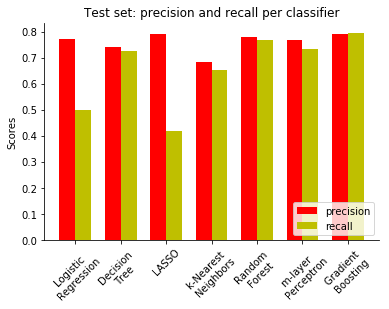

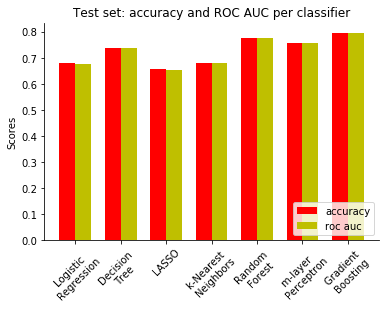

In [43]:
test_precisions = [np.mean(logit_test_precision), np.mean(tree_test_precision),
                   np.mean(lasso_test_precision), np.mean(knn_test_precision),
                   np.mean(forest_test_precision), np.mean(tron_test_precision),
                   np.mean(boost_test_precision)]

test_recalls = [np.mean(logit_test_recall), np.mean(tree_test_recall),
                   np.mean(lasso_test_recall), np.mean(knn_test_recall),
                   np.mean(forest_test_recall), np.mean(tron_test_recall),
                   np.mean(boost_test_recall)]

accuracy = [np.mean(logit_test_acc), np.mean(tree_test_acc),
                   np.mean(lasso_test_acc), np.mean(knn_test_acc),
                   np.mean(forest_test_acc), np.mean(tron_test_acc),
                   np.mean(boost_test_acc)]

roc_auc = [np.mean(logit_test_roc_auc), np.mean(tree_test_roc_auc),
                   np.mean(lasso_test_roc_auc), np.mean(knn_test_roc_auc),
                   np.mean(forest_test_roc_auc), np.mean(tron_test_roc_auc),
                   np.mean(boost_test_roc_auc)]

names = ['Logistic \nRegression', 'Decision \nTree', 'LASSO', 'k-Nearest \nNeighbors', 
         'Random \nForest', 'm-layer \nPerceptron', 'Gradient \nBoosting'] 

print("Precisions and recalls for single models")
plot_precision_recall(test_precisions, test_recalls, accuracy, roc_auc, names)

GradientBoosting remains the best fit for our data, and even our ensemble is not outperforming GB.

So let's explore GB output and do some error analysis.

In [44]:
''' TP, FN
    FP, TN'''

array = np.zeros((2,2))
array[0,0] = confusion_string[-1]
array[0,1] = confusion_string[2]
array[1,0] = confusion_string[1]
array[1,1] = confusion_string[0]

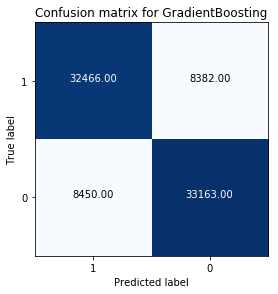

In [45]:
def plot_confusion_matrix(matrix, title, classes, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

plot_confusion_matrix(array, 'Confusion matrix for GradientBoosting', [1,0])

plt.show()

### Error Analysis

In [46]:
# Split data into 0.8 train and 0.2 test

np.random.seed(seed=13579)

train_idx = np.random.choice(range(len(df_b2_ri_n)), int(len(df_b2_ri_n) * .8), replace=False)
test_idx = list(set(range(len(df_b2_ri_n))) - set(list(train_idx)))

train_x = df_b2_ri_n.loc[train_idx, new_feature_names]
train_y = df_b2_ri_n.loc[train_idx, label_name]
test_x = df_b2_ri_n.loc[test_idx, new_feature_names]
test_y = df_b2_ri_n.loc[test_idx, label_name]

logit = LogisticRegression()
logit.fit(train_x, train_y)

tree = DecisionTreeClassifier(random_state=13579, max_depth=18)
tree.fit(train_x, train_y)

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

forest = RandomForestClassifier(random_state=13579, max_depth=18)
forest.fit(train_x, train_y)

tron = MLPClassifier(solver='lbfgs', random_state=13579)
tron.fit(train_x, train_y)

boost = GradientBoostingClassifier(random_state=13579, max_depth=7)
boost.fit(train_x, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=13579, subsample=1.0, verbose=0,
              warm_start=False)

In [47]:
test_x.head()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_7_30,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3
0,-0.052081,-0.057062,-0.134654,-0.010707,-0.003978,0.101153,-0.117923,-0.076264,0.059739,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
65538,-0.058577,-0.087776,-0.138964,0.003745,-0.009132,0.058864,-0.034524,-0.099102,-0.092772,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32772,-0.049208,-0.071577,-0.170759,0.005576,-0.001401,0.074527,-0.069675,-0.142239,0.020706,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32773,-0.057520,-0.087729,-0.172387,0.005461,-0.000886,0.077660,-0.090617,-0.158830,0.165131,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101
32776,-0.059897,-0.090443,-0.162236,0.004059,0.002722,0.071395,-0.064844,-0.017368,-0.051507,-0.164703,...,-0.018941,-0.016098,-0.019896,-0.074512,0.006581,-0.007118,-0.001864,0.003518,-0.012419,-0.013101


In [48]:
d_test = {'logit': logit.predict(test_x) == test_y, 
          'tree': tree.predict(test_x) == test_y,
          'lasso': lasso.predict(test_x) == test_y,
          'knn': knn.predict(test_x) == test_y,
          'forest': forest.predict(test_x) == test_y,
          'tron': tron.predict(test_x) == test_y,
          'boost': boost.predict(test_x) == test_y}

df_test = pd.DataFrame(data=d_test)
df_test.head()

,boost,forest,knn,lasso,logit,tree,tron
0,True,True,True,True,True,False,True
65538,True,False,True,False,False,False,True
32772,False,False,True,False,False,False,False
32773,True,True,False,True,True,True,False
32776,False,False,False,False,False,False,False


Compare true negatives to false positives and true positives to false negatives.

Why weren't false positives classified as negatives (which they really are) and false negatives as positives (which they really are)? As our analysis suggests, "falses" did not provide a clear signal via features to the classifiers. We compared tn-fp and tp-fp along a few significant features (average and the latest size of the article, total views and change in views in the latest 3 days) and found that misclassified articles indeed are dissimilar to a class they actually belong to.

In [89]:
#type(df_test)
#df_test[2:9]

misclassified = df_test.loc[(df_test['boost'] == False) & 
            (df_test['forest'] == False) &
            (df_test['knn'] == False) & 
            (df_test['lasso'] == False) &
            (df_test['logit'] == False) & 
            (df_test['tree'] == False) &
            (df_test['tron'] == False)
           ]

classified_correctly = df_test.loc[(df_test['boost'] == True) & 
            (df_test['forest'] == True) &
            (df_test['knn'] == True) & 
            (df_test['lasso'] == True) &
            (df_test['logit'] == True) & 
            (df_test['tree'] == True) &
            (df_test['tron'] == True)
           ]

df_false_true = df_b2_ri.copy(deep=True)

df_false = df_false_true.loc[misclassified.index.tolist(),:]

df_true = df_false_true.loc[classified_correctly.index.tolist()]

In [90]:
print(df_b2_ri.shape)
df_b2_ri.head()

(82461, 51)


,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
0,76445.166667,104414.0,881.0,-11.836957,-2.75,9.5,0.642247,0.870588,1.513514,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
1,32865.733333,16414.0,348.0,0.989130,1.25,-0.5,1.080674,1.094340,0.965517,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
2,27468.766667,20318.0,410.0,-3.521739,-3.50,9.5,0.773109,0.708333,2.117647,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
3,25624.800000,22847.0,1193.0,-7.880435,7.75,-9.0,0.812951,1.226277,0.785714,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
4,24599.900000,47473.0,149.0,0.086957,-2.00,7.0,1.014706,0.666667,2.750000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0


In [91]:
print(df_false_true.shape)
print(df_false.shape)
print(df_true.shape)

(82461, 51)
(897, 51)
(6570, 51)


In [92]:
df_false.head()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
32776,12989.566667,13232.0,305.0,-2.108696,0.50,0.0,0.818352,1.052632,1.000000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
32783,25019.357143,75321.0,17.0,0.184783,-0.25,-0.5,1.118056,0.857143,0.666667,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
65557,123144.633333,41373.0,508.0,-8.750000,-0.75,1.5,0.562500,0.933333,1.142857,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
115,20143.750000,16476.0,40.0,0.489130,0.25,-2.0,1.216346,1.090909,0.333333,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
116,21496.157895,12498.0,31.0,-0.086957,-1.00,2.0,0.958333,0.500000,3.000000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1


In [93]:
df_true.head()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
9,12573.875000,12590.0,8.0,-0.010870,-0.25,1.0,0.991379,0.800000,2.000000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
11,109073.433333,146291.0,243.0,-3.163043,0.25,-3.0,0.680921,1.037037,0.571429,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
32782,6557.000000,6557.0,1.0,-0.043478,0.00,0.0,0.958333,1.000000,1.000000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0
32785,193517.633333,43031.0,1212.0,-8.760870,-16.00,-6.5,0.806436,0.561644,0.682927,9.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
65558,47717.766667,30636.0,240.0,1.673913,-2.50,1.0,1.189655,0.761905,1.125000,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0


#### TN vs. FP:

In [94]:
t_grouped = df_true.groupby('num_edits_binary')
t_grouped.get_group(0).describe()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
count,4.152000e+03,4.152000e+03,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,...,4152.000000,4152.0,4152.0,4152.0,4152.0,4152.0,4152.0,4152.0,4152.0,4152.0
mean,6.130303e+04,5.471519e+04,273.114884,-0.332878,-0.355250,0.039619,0.965193,1.015053,1.212058,0.009393,...,0.999304,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
std,9.688326e+04,8.462070e+04,551.162917,8.361708,12.814147,7.368926,0.251907,0.360225,0.619814,0.103694,...,0.014036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,4.660500e+03,0.000000e+00,1.000000,-174.021739,-675.000000,-244.500000,0.167561,0.015317,0.142857,0.000000,...,0.444444,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
25%,8.134386e+03,7.019500e+03,3.000000,-0.902174,-1.000000,-0.500000,0.851852,0.823127,0.941176,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
50%,3.807400e+04,3.320650e+04,97.000000,-0.043478,0.000000,0.000000,0.958333,1.000000,1.000000,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
75%,7.219920e+04,6.285025e+04,307.250000,0.206522,0.500000,2.000000,1.055046,1.092816,1.333333,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
max,2.953722e+06,2.178114e+06,13922.000000,199.456522,230.750000,122.000000,4.878324,6.275862,6.206897,2.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [95]:
f_grouped = df_false.groupby('num_edits_binary')
f_grouped.get_group(1).describe()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
count,6.540000e+02,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,654.000000,...,654.000000,654.0,654.0,654.0,654.0,654.0,654.0,654.0,654.0,654.0
mean,5.799246e+04,48930.015291,407.934251,-0.974006,-0.214067,-0.752294,0.941501,1.007517,1.258061,0.030581,...,0.999694,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
std,1.145345e+05,71304.811419,807.804709,8.258455,6.256302,9.445165,0.250466,0.367868,0.803306,0.197179,...,0.007821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,4.570800e+03,0.000000,1.000000,-116.217391,-71.750000,-106.500000,0.070172,0.250000,0.153846,0.000000,...,0.800000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
25%,2.224083e+04,18842.750000,26.500000,-1.456522,-1.250000,-1.500000,0.811753,0.800000,0.800000,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
50%,3.645343e+04,30536.500000,149.000000,-0.173913,0.000000,0.000000,0.928897,1.000000,1.000000,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
75%,5.822015e+04,53245.500000,485.000000,0.377717,0.750000,2.000000,1.078125,1.128825,1.444444,0.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
max,2.192460e+06,797837.000000,11325.000000,35.706522,45.000000,68.000000,2.830769,3.125000,7.600000,2.000000,...,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


MAY NEED TO UPDATE NUMBERS HERE

*A few major features for false positive class are misleadingly high and distinguish this class from true negatives. In the false positives, median values for avg_size, latest_size, and total_views are higher than those typical for true negative class (45989 > 41299, 36506 > 33186, and 560 > 191), median change in views for the last 3 days is smaller, negative 1.5 vs. 0 for true negative.*

#### TP vs. FN:

In [96]:
t_grouped.get_group(1).describe()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
count,2.418000e+03,2.418000e+03,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,...,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.000000,2418.0
mean,2.105295e+06,1.047846e+06,16926.841191,-18.006563,-6.490074,-97.306038,1.340748,1.689722,1.844916,19.189826,...,1.014414,1.021935,0.123242,0.000108,0.001241,-0.002068,1.000266,1.002419,1.001062,1.0
std,1.073634e+07,3.276041e+06,35268.570594,980.674625,900.279172,539.034274,4.286420,11.500947,11.064871,42.354171,...,0.393660,0.416060,0.596942,0.044190,0.162082,0.146663,0.041710,0.158426,0.060354,0.0
min,7.347857e+03,7.149000e+03,6.000000,-8078.260870,-31809.500000,-7818.500000,0.018856,0.075472,0.009387,0.000000,...,0.142857,0.210526,0.000000,-0.260870,-1.250000,-6.500000,0.793103,0.444444,0.235294,1.0
25%,6.066522e+04,5.932250e+04,779.000000,-29.812500,-26.500000,-113.500000,0.766739,0.827143,0.664506,4.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
50%,2.474806e+05,2.065400e+05,5228.000000,-2.081522,-2.000000,-20.500000,0.962694,0.966593,0.819916,8.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
75%,1.094170e+06,7.661872e+05,16795.250000,14.086957,11.250000,2.000000,1.133974,1.118510,1.076923,20.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.0
max,3.174644e+08,8.503612e+07,471035.000000,33101.782609,9635.000000,10818.000000,153.416159,495.102564,428.400000,1190.000000,...,19.000000,18.000000,16.000000,1.032609,7.500000,1.000000,1.848214,8.500000,2.000000,1.0


In [97]:
f_grouped.get_group(0).describe()

,avg_size,latest_size,total_views,change_in_views_v1_7_30,change_in_views_v1_3_7,change_in_views_v1_1_3,change_in_views_v2_7_30,change_in_views_v2_3_7,change_in_views_v2_1_3,total_edits,...,change_in_talk_edits_v2_3_7,change_in_talk_edits_v2_1_3,total_talk_minor_edits,change_in_talk_minor_edits_v1_7_30,change_in_talk_minor_edits_v1_3_7,change_in_talk_minor_edits_v1_1_3,change_in_talk_minor_edits_v2_7_30,change_in_talk_minor_edits_v2_3_7,change_in_talk_minor_edits_v2_1_3,num_edits_binary
count,2.430000e+02,2.430000e+02,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,...,243.000000,243.0,243.000000,243.000000,243.0,243.0,243.000000,243.0,243.0,243.0
mean,5.859536e+05,2.652069e+05,8471.312757,-98.256710,-25.605967,-47.915638,1.058117,1.075942,0.944539,8.950617,...,0.999177,1.0,0.032922,-0.001431,0.0,0.0,0.998682,1.0,1.0,0.0
std,2.527153e+06,3.689233e+05,35517.198321,1498.525635,321.648221,136.128138,0.867240,0.831798,0.569024,13.158507,...,0.012830,0.0,0.255005,0.011087,0.0,0.0,0.010062,0.0,0.0,0.0
min,1.775690e+04,6.698000e+03,60.000000,-22521.336957,-4702.250000,-1042.500000,0.028293,0.118157,0.199134,0.000000,...,0.800000,1.0,0.000000,-0.130435,0.0,0.0,0.884615,1.0,1.0,0.0
25%,6.265678e+04,4.689200e+04,816.500000,-19.875000,-18.500000,-51.500000,0.772956,0.791557,0.643555,2.000000,...,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0,0.0
50%,1.754646e+05,1.286280e+05,3294.000000,-2.076087,-3.750000,-12.500000,0.953455,0.953967,0.808511,5.000000,...,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0,0.0
75%,3.777905e+05,3.090485e+05,8066.500000,7.521739,7.375000,1.000000,1.160330,1.110398,1.048501,10.000000,...,1.000000,1.0,0.000000,0.000000,0.0,0.0,1.000000,1.0,1.0,0.0
max,3.811419e+07,2.216759e+06,537460.000000,4752.663043,911.500000,352.500000,9.980009,8.166667,5.033333,114.000000,...,1.000000,1.0,3.000000,0.000000,0.0,0.0,1.000000,1.0,1.0,0.0


MAY NEED TO UPDATE NUMBERS HERE

*In the false negatives, median values for avg_size and total_views are lower than those typical for true negative class (42261 < 43969 and 214 < 480), while the latest_size is comparable (33019 > 32925). Median change in views for the last 3 days is also similar to true positive, namely 0.*

How much overlap in predictions is there among the classifiers?

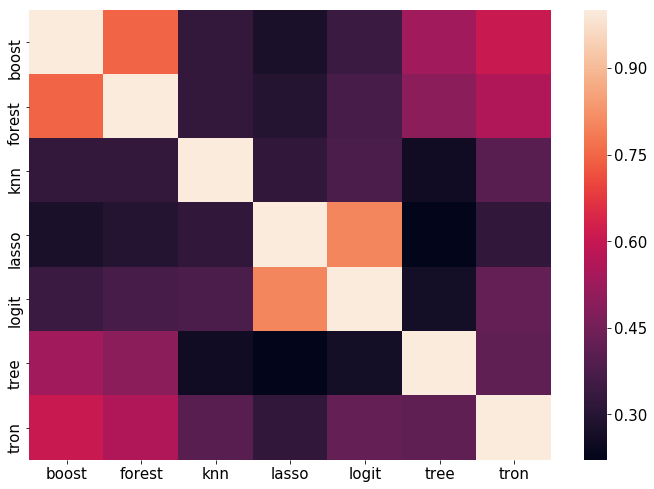

In [111]:
corr = df_test.corr()

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.rcParams.update({'font.size': 15})

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax = ax)
plt.show()

From the heatmap above we can see that there is around 75% overlap in the predictions made by RandomForest and GradientBoosting, while LASSO and DecisionTree have less than 30% overlap.

### Feature importances

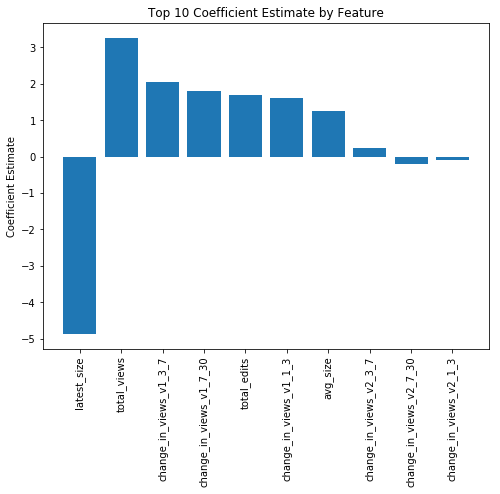

In [136]:
plot_lim = 10

# Logistic regression

logit = LogisticRegression()
logit.fit(train_x, train_y)

logit_coefficients = logit.coef_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(np.abs(logit_coefficients[0]), range(plot_lim)), reverse=True)))
coefs = [logit_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

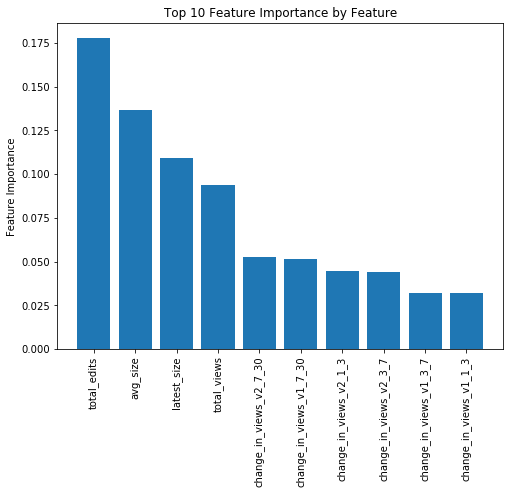

In [137]:
# Decision tree

tree = DecisionTreeClassifier(random_state=13579)
tree.fit(train_x, train_y)

feature_importances = tree.feature_importances_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]
plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

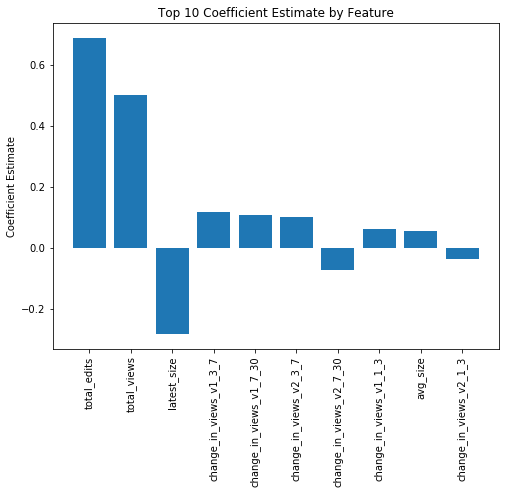

In [138]:
# LASSO

lasso = LogisticRegression(penalty = 'l1')
lasso.fit(train_x, train_y)

lasso_coefficients = lasso.coef_

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

_, sort_i = list(zip(*sorted(zip(np.abs(lasso_coefficients[0]), range(plot_lim)), reverse=True)))
sorted_coefs = [lasso_coefficients[0][i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

plt.bar(range(plot_lim), sorted_coefs, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Coefficient Estimate')
ax.set_title('Top 10 Coefficient Estimate by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

In [ ]:
# K-nearest neighbors (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

np.random.seed(seed=13579)

knn = KNeighborsClassifier()

knn_features = features
knn_target = 'num_edits_binary'

old_vars = []

final_lst = []

while len(knn_features) > 0:
    one_run = []
    for feature in knn_features:
        one_run += [[np.mean(cross_val_score(knn, 
                                             df_b2_ri_n[old_vars + [feature]], 
                                             df_b2_ri_n[target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0], reverse=True)
    final_lst += [one_run[0]]
    old_vars += [one_run[0][1]]
    knn_features = [f for f in knn_features if f != one_run[0][1]]
    if len(final_lst) >= 2 and final_lst[-1][0] < final_lst[-2][0]:
        final_lst = final_lst[:-1]
        break

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Forward Selection")

plt.show()

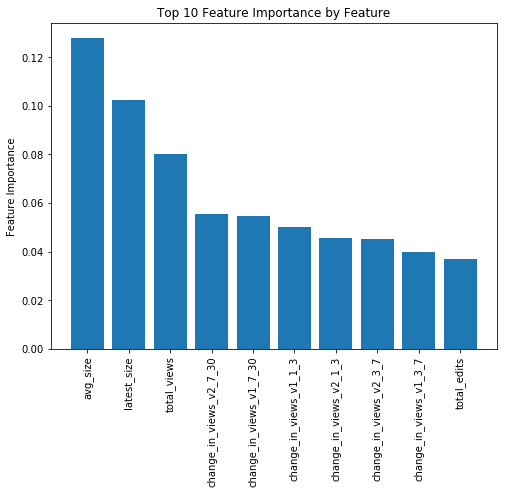

In [139]:
# Random forest

forest = RandomForestClassifier(random_state=13579)
forest.fit(train_x, train_y)

feature_importances = forest.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

In [ ]:
# Multi-layer perceptron (TAKES FOREVER TO RUN, IGNORE FOR NOW)
# TODO: Update to grab just top 10 features.

tron_features = features
tron_target = 'num_edits_binary'

final_lst = []

while len(tron_features) > 1:
    one_run = []
    for feature in tron_features:
        tron = MLPClassifier(solver='lbfgs', random_state=13579)
        one_run += [[np.mean(cross_val_score(tron, 
                                             df_b2_ri_n[list(set(tron_features) - set([feature]))], 
                                             df_b2_ri_n[tron_target], 
                                             cv=2)), 
                     feature]]
    one_run.sort(key = lambda x: x[0])
    final_lst += [one_run[0]]
    tron_features = [f for f in tron_features if f != one_run[0][1]]
    print(tron_features)

plt.plot([i for i in range(len(final_lst))],
            [final_lst[i][0] for i in range(len(final_lst))], "-o")

labels = [final_lst[i][1] for i in range(len(final_lst))]

plt.xticks([i for i in range(len(final_lst))], 
           labels, rotation='vertical')

plt.ylabel("Accuracy")
plt.title("Backward Selection")

plt.show()

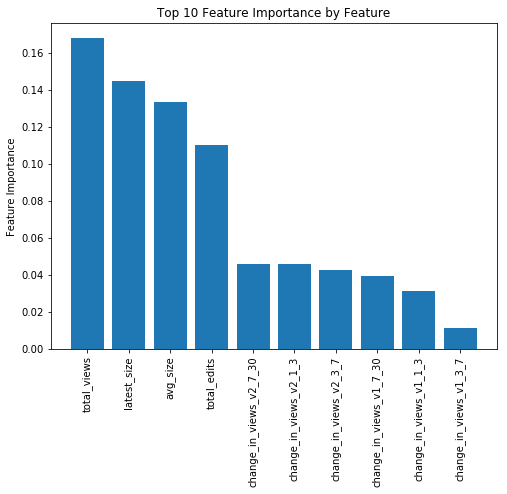

In [140]:
# Gradient boosting

boost = GradientBoostingClassifier(random_state=13579)
boost.fit(train_x, train_y)

feature_importances = boost.feature_importances_
_, sort_i = list(zip(*sorted(zip(feature_importances, range(plot_lim)), reverse=True)))
sorted_feature_importances = [feature_importances[i] for i in sort_i]
sorted_cols = [train_x.columns[i] for i in sort_i]

#ax = plt.gca()
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

plt.bar(range(plot_lim), sorted_feature_importances, align='center')
plt.xticks(range(plot_lim), sorted_cols, rotation='vertical')
ax.set_ylabel('Feature Importance')
ax.set_title('Top 10 Feature Importance by Feature')

#fig_size = plt.rcParams["figure.figsize"]
#fig_size[0] = 24
#fig_size[1] = 18
#plt.rcParams["figure.figsize"] = fig_size

plt.rcParams.update({'font.size': 10})

plt.show()

**Analysis**

* It seems like for different models, different features are more important. Very often, it is total_views, total_talk_views, total_edits, as well as avg_size and latest_size (but not for lasso and logistic regression). 

* We can try some dimensionality reduction techniques, like principal component analysis (PCA) to see if it is possible to cut on the number of features without damage to explained variance.

In [126]:
# We'll use Minka’s MLE to guess the dimensions

pca = PCA(n_components='mle', svd_solver='full')
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components='mle', random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [127]:
print("initial number of features: ", len(new_feature_names))

initial number of features:  50


In [128]:
print("after dimensionality resuction: ", pca.n_components_)

after dimensionality resuction:  49


The PCA results suggest that ~50 is the reasonable number of features for this data set. This is an expected result, since our data is not very sparse (sparsity is one use case for PCA), and 50 dimensions is not too much (high dimensionality - another use case). 